### Background
- Необходимость сократить время на осуществление относительно простых, но в тоже время рутинных и часто возникающих CFD-расчетов трубопроводов различного назначения

### Purpose
- Оценить состоятельность и эффективность применения Deep Convolutional Neural Networks для решения поставленной задачи, а также общие трудо- и время- затраты (на обучение модели и т.д.)
- Применить полученные на курсе знания и навыки для решения практической (насущной) задачи
- Получить новый опыт

---
- `FinalProject_ModelListGeneration.py` - скрипт генерации параметров геометрии CFD моделей
- `FinalProject_CadModelGeneration.ipynb` - скрипт генерации CAD моделей по параметрам
- `FinalProject_CfdModelGeneration.FCMacro` - скрипт генерации CFD моделей из CAD
- `runALLAllmesh`, `runALLAllrun` - скрипты запуска генерации расчетной сетки и запуска CFD расчета
- `FinalProject_GettingResults_v1.py` - скрипт извлечения результатов



[DATA EXAMPLES](https://drive.google.com/drive/folders/1BUo5T81UsoqGpVlbbAevScY0er5NXZrp?usp=sharing)

---

In [ ]:
# from platform import python_version

# print(python_version())

In [ ]:
# libraries importing
import os, glob, itertools, re, pickle, json, random, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm, trange

from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from FinalProject_ModelListGeneration import get_models_list

In [ ]:
# environment setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
DATA_PATH = 'D:\\DataScience\\FinalProject\\cfd_results\\10mm'

## Data importing

### Tabular data

In [ ]:
# # getting list with models parameters
# models = get_models_list()

# models = models[models['diameter']==10]
# models.reset_index(drop=True, inplace=True)
# models.drop(columns=['diameter'], inplace=True)

# display(models.head(3), models.shape)

In [ ]:
# # getting cfd-analysis tabular results data
# tables_list = glob.glob(os.path.join(DATA_PATH, '*', '*.csv'))

# for i, table in enumerate(tables_list):
#     if i == 0:
#         results = pd.read_csv(table)
#     else:
#         results = results.append(pd.read_csv(table), ignore_index=True)

# display(results.head(3), results.shape)

In [ ]:
# # concatenate data (parameters + cfd-results)
# models = models.merge(results, how='right', on='description')

# display(models.head(3), models.shape)

#### Preprocessing

- Для обучения нейросети будем использовать отдельно каждую "секцию" по отдельности со своими распределениями скоростей и давления на входном и выходном сечениях. Так же "дадим модели знать" о параметрах предыдущей и последующей секциях.

In [ ]:
# # list of necessary data for learning
# data = {'before_size':[],
#         'before_shape':[],
#         'before_direction':[],
#         'current_size':[],
#         'current_shape':[],
#         'current_direction':[],
#         'after_size':[],
#         'after_shape':[],
#         'after_direction':[],
#         'inlet-P_min':[],
#         'inlet-P_max':[],
#         'inlet-UX_min':[],
#         'inlet-UX_max':[],
#         'inlet-UY_min':[],
#         'inlet-UY_max':[],
#         'inlet-UZ_min':[],
#         'inlet-UZ_max':[],
#         'outlet-P_min':[],
#         'outlet-P_max':[],
#         'outlet-UX_min':[],
#         'outlet-UX_max':[],
#         'outlet-UY_min':[],
#         'outlet-UY_max':[],
#         'outlet-UZ_min':[],
#         'outlet-UZ_max':[]
#        }

In [ ]:
# # getting each section of model as one data row
# for i in range(len(models)):
    
#     section_count = int((len(models['description'][i].split('-'))-1)/3)
    
#     '''
#     Getting parameters of current section and also previous and next sections.
#     If section is first or last set 0 for the all parameters of
#     previous or next section respectively.
#     '''
#     for j in range(section_count):
#         for x in range(0,7,3):
#             for y,column in enumerate(list(data.keys())[x:x+3]):
#                 if x == 3:
#                     data[column].append(models.iloc[i, j+3*y])
#                 elif x == 0:
#                     if j == section_count-1 or j == 0:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j-1+3*y])
#                 else:
#                     if j == section_count-1:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j+1+3*y])
        
#         '''
#         Getting results of section INLET and OUTLET
#         '''
#         inlet_idx = 's'+str(j)
#         outlet_idx = 's'+str(j+1)
        
#         d = {'inlet':inlet_idx,
#              'outlet':outlet_idx}
        
#         cnt = 0
        
#         for column in list(data.keys())[9:25]:
#             cnt += 1
#             result = column.split('-')
#             data[column].append(models[d[result[0]]+'-'+result[1]][i])
            
#             ## getting path to images 
#             if cnt % 2 == 0:
#                 result[1] = result[1].split('_')[0]
                
#                 new_column = result[0]+'-'+result[1]+'_image'
#                 img_name = d[result[0]]+'-'+result[1]+'.png'
#                 path2img = glob.glob(os.path.join(DATA_PATH, '*', models['description'][i], img_name))[0]
                
#                 if new_column not in list(data.keys()):
#                     data[new_column] = []
#                 data[new_column].append(path2img)

In [ ]:
# df = pd.DataFrame(data)

# display(df.head(3), df.shape)

In [ ]:
# df.info()

In [ ]:
# # Lable encoding
# encoder = LabelEncoder()

# for column in list(df.columns)[:-int(cnt/2)]:
#     if df[column].dtypes == 'O':
#         df[column] = df[column].apply(str)
#         df[column] = encoder.fit_transform(df[column])

# display(df.head(3), df.shape)

- Дабы при каждом перезапуске не проводить преобразование выше, сохраним датафрейм и далее будем подгружат данные из него

In [ ]:
# df.to_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'), index=False)

In [ ]:
df = pd.read_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'))
display(df.head(3), df.shape)

In [ ]:
df.info()

In [ ]:
rslt = list(df.columns)[9:-8]

n_rslt = len(rslt)

fig, axs = plt.subplots(int(n_rslt/2), 2, figsize=(20, n_rslt*3))

for i, j in enumerate(rslt):
    min_value=round(df[j].min(), 1)
    max_value=round(df[j].max(), 1)

    axs[i//2][i%2].hist(df[j], bins='auto')
    axs[i//2][i%2].set_title(f'{j}: Min.val.={min_value}, Max.val.={max_value}')
    axs[i//2][i%2].grid(True, axis='y', alpha=0.5)
    axs[i//2][i%2].set_ylabel('Count')

### Image data

In [ ]:
def get_img_samples(n_smpl=5, df=df, s_sart=-8, s_end=None):

    plt.figure(figsize=(20, n_smpl*2))

    for i, (x, y) in enumerate(itertools.product(df.sample(n_smpl).index, list(df.columns)[s_sart:s_end])):
        file_name = df[y][x]
        img = Image.open(file_name)
        plt.subplot(n_smpl, 8, i+1)
        plt.imshow(img)
        plt.title(f"{x}-{y}")
        plt.axis('off')

    plt.show()

In [ ]:
get_img_samples()

#### Preprocessing

In [ ]:
img_path = df['inlet-P_image'][2924]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# plt.figure(figsize=(20,20))
plt.imshow(img, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img)

In [ ]:
print(f"Max.val.= {df['inlet-P_max'][2924]},\nMin.val.= {df['inlet-P_min'][2924]}")

In [ ]:
def get_preprocessed_image(column, row, ratio=4, df=df, save=False, data_path=DATA_PATH):
    
    '''loading image'''
    img_path = df[column][row]
    # as single channel image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # downsizing
    img_h, img_w = img.shape
    assert img_h % ratio == 0 and img_w % ratio == 0, 'Image size must be even divisible by resizing ratio'
    new_size = (img_w//ratio, img_h//ratio)
    img_changed = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    
    # normalize pixels value (optional)
    img_changed = img_changed/255

    '''scaling'''
    img_h, img_w = img_changed.shape
    # values range
    max_val = df[column.replace('image', 'max')][row]
    min_val = df[column.replace('image', 'min')][row]
    # pixels value range
    max_val_px = np.unique(img_changed)[-1]
    min_val_px = np.unique(img_changed)[1]

    '''set real value as pixel grey value'''
    for h, w in list(itertools.product(range(img_h), range(img_w))):
        '''
        If a pixel has a value of 0, it means that it is outside the pipe cross section
        Set it to the value of atmospheric pressure, in the case of CFD analysis equal to 0.
        '''
        if img_changed.item(h, w) != 0:
            real_val = (img_changed.item(h, w)-min_val_px)\
                        * (max_val-min_val)/(max_val_px-min_val_px) + min_val
        else:
            real_val = 0

        img_changed.itemset((h, w), real_val / 127.5)

    '''saving preprocessed image, if required'''
    if save:
        found_names = re.findall(r"\d+.+?[^\\]*", img_path)
        batch_name = found_names[1]
        model_name = found_names[2]
        img_name = os.path.basename(img_path)

        save_path = os.path.join(data_path.replace('cfd_results', 'img_preprocessing'),
                                 batch_name,
                                 model_name)
        os.makedirs(save_path, exist_ok=True)
        '''
        The adding 127.5 to each pixel shifts the zero to a mid-grey value,
        shows negative values as darker, and positive values as lighter.
        '''
        cv2.imwrite(os.path.join(save_path, img_name), img_changed + 127.5)

    return np.array(img_changed.astype('float32')), img_h, img_w

---
##### Checking function work

In [ ]:
img_changed, _, _ = get_preprocessed_image(column='inlet-P_image',
                                           row=2924)

# plt.figure(figsize=(20,20))
plt.imshow(img_changed, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img_changed)

---

In [ ]:
# Lable encoding
encoder = LabelEncoder()

for column in list(df.columns):
    if 'size' in column:
        df[column] = df[column].apply(int)
        df[column] = encoder.fit_transform(df[column])

display(df.head(3), df.shape)

In [ ]:
# def get_geom_channel(row, df=df, img_h=512, img_w=512):
    
#     h = img_h//3 + 1
#     w = img_w//3 + 1
    
#     '''create filled with zeros array'''
#     s = (img_h, img_w)
#     geom_param = np.zeros(s)
    
#     '''fill by previous geom'''
#     geom_param[:] = df[list(df.columns)[0]][row]
#     geom_param[:,w:] = df[list(df.columns)[1]][row]
#     geom_param[:,-w:] = df[list(df.columns)[2]][row]
    
#     '''fill by current geom'''
#     geom_param[h:] = df[list(df.columns)[3]][row]
#     geom_param[h:,w:] = df[list(df.columns)[4]][row]
#     geom_param[h:,-w:] = df[list(df.columns)[5]][row]
    
#     '''fill by next geom'''
#     geom_param[-h:] = df[list(df.columns)[6]][row]
#     geom_param[-h:,w:] = df[list(df.columns)[7]][row]
#     geom_param[-h:,-w:] = df[list(df.columns)[8]][row]
    
#     return geom_param.astype('float32')

In [ ]:
def get_geom_channel(row, df=df, img_h=512, img_w=512):
    
    s = (img_h, img_w)
    geom_param = np.zeros(s)
    
    for (h, w), i in zip(itertools.product(range(img_h), range(img_w)), itertools.cycle(list(df.columns)[:9])):
        geom_param.itemset((h, w), df[i][row])
    
    return geom_param.astype('float32')

---
##### Checking function work

In [ ]:
df.iloc[2924]

In [ ]:
geom_param = get_geom_channel(2924)

# plt.figure(figsize=(20,20))
plt.imshow(geom_param, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(geom_param)

---
## Dataset preparing

In [ ]:
def get_channels_set(column_list, row, df=df, with_geom=True):
    
    channels_set = []
    
    for column in column_list:
        value_channel, img_h, img_w = get_preprocessed_image(column=column,
                                                             row=row,
                                                             df=df)
        channels_set.append(value_channel)
    
    if with_geom:
        geom_channel = get_geom_channel(row=row,
                                        df=df,
                                        img_h=img_h,
                                        img_w=img_w)
        channels_set.append(geom_channel)

    return channels_set

In [ ]:
dataset_lists = {'dataX_model_V':[['inlet-UX_image',
                                   'inlet-UY_image',
                                   'inlet-UZ_image'], True],
                 
                 'dataX_model_P':[['outlet-P_image',
                                   'inlet-UX_image',
                                   'inlet-UY_image',
                                   'inlet-UZ_image'], False],
                 
                 'dataY_model_V':[['outlet-UX_image',
                                   'outlet-UY_image',
                                   'outlet-UZ_image'], False],
                 
                 'dataY_model_P':[['inlet-P_image'], False]}

In [ ]:
for ds in list(dataset_lists.keys()):

    data = Parallel(n_jobs=-1)(delayed(get_channels_set)(column_list=dataset_lists[ds][0],
                                                         with_geom=dataset_lists[ds][1],
                                                         row=row) for row in trange(len(df)))
    f = open(ds + '.pkl', 'wb')
    pickle.dump(data, f)
    f.close()
    del data

---
##### Checking function work

In [ ]:
x = pickle.load(open("dataX_model_V.pkl", "rb"))

plt.figure(figsize=(20,4))

for i in range(len(x[0])):
    plt.subplot(1, len(x[0]), i+1)
    plt.imshow(x[2924][i], cmap='gray')
    plt.colorbar()

---

# DCNN

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

import copy

In [ ]:
!nvidia-smi -L

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_SEED)

### Helper functions

In [ ]:
def split_tensors(*tensors, ratio):
    assert len(tensors) > 0
    split1, split2 = [], []
    count = len(tensors[0])
    for tensor in tensors:
        assert len(tensor) == count
        split1.append(tensor[:int(len(tensor) * ratio)])
        split2.append(tensor[int(len(tensor) * ratio):])
    if len(tensors) == 1:
        split1, split2 = split1[0], split2[0]
    return split1, split2

In [ ]:
def create_layer(in_channels,
                 out_channels,
                 kernel_size,
                 wn=True,
                 bn=True,
                 activation=nn.ReLU,
                 convolution=nn.Conv2d):

    assert kernel_size % 2 == 1
    layer = []
    conv = convolution(in_channels,
                       out_channels,
                       kernel_size,
                       padding=kernel_size//2)
    if wn:
        conv = weight_norm(conv)
    
    layer.append(conv)
    
    if activation is not None:
        layer.append(activation())
    
    if bn:
        layer.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layer)

In [ ]:
def create_encoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2):
    
    encoder = []
    for i in range(layers):
        _in = out_channels
        _out = out_channels
        if i == 0:
            _in = in_channels
        encoder.append(create_layer(_in, _out, kernel_size, wn, bn, activation, nn.Conv2d))
    return nn.Sequential(*encoder)

In [ ]:
def create_decoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2,
                         final_layer=False):
    
    decoder = []
    for i in range(layers):
        _in = in_channels
        _out = in_channels
        _bn = bn
        _activation = activation
        if i == 0:
            _in = in_channels * 2
        if i == layers - 1:
            _out = out_channels
            if final_layer:
                _bn = False
                _activation = None
        decoder.append(create_layer(_in, _out, kernel_size, wn, _bn, _activation, nn.ConvTranspose2d))
    return nn.Sequential(*decoder)

In [ ]:
def create_encoder(in_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    encoder = []
    for i in range(len(filters)):
        if i == 0:
            encoder_layer = create_encoder_block(in_channels,
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        else:
            encoder_layer = create_encoder_block(filters[i-1],
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        encoder = encoder + [encoder_layer]
    return nn.Sequential(*encoder)

In [ ]:
def create_decoder(out_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    decoder = []
    for i in range(len(filters)):
        if i == 0:
            decoder_layer = create_decoder_block(filters[i],
                                                 out_channels,
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=True)
        else:
            decoder_layer = create_decoder_block(filters[i],
                                                 filters[i-1],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=False)
        decoder = [decoder_layer] + decoder
    return nn.Sequential(*decoder)

In [ ]:
def initialize(model, gain=1, std=0.02):
    for module in model.modules():
        if type(module) in [nn.Linear, nn.Conv1d, nn.Conv2d, nn.Conv3d]:
            nn.init.xavier_normal_(module.weight, gain)
            if module.bias is not None:
                nn.init.normal_(module.bias, 0, std)

In [ ]:
def epoch(scope, loader, on_batch=None, training=False):
    model = scope["model"]
    optimizer = scope["optimizer"]
    loss_func = scope["loss_func"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)
    scope["loader"] = loader

    metrics_list = generate_metrics_list(metrics_def)
    total_loss = 0
    if training:
        model.train()
    else:
        model.eval()
    for tensors in loader:
        
        if "process_batch" in scope and scope["process_batch"] is not None:
            tensors = scope["process_batch"](tensors)
        if "device" in scope and scope["device"] is not None:
            tensors = [tensor.to(scope["device"]) for tensor in tensors]
            
        loss, output = loss_func(model, tensors)
        
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        total_loss += loss.item()
        
        scope["batch"] = tensors
        scope["loss"] = loss
        scope["output"] = output
        scope["batch_metrics"] = {}
        
        for name, metric in metrics_def.items():
            value = metric["on_batch"](scope)
            scope["batch_metrics"][name] = value
            metrics_list[name].append(value)
        if on_batch is not None:
            on_batch(scope)
    scope["metrics_list"] = metrics_list
    metrics = {}
    for name in metrics_def.keys():
        scope["list"] = scope["metrics_list"][name]
        metrics[name] = metrics_def[name]["on_epoch"](scope)
    return total_loss, metrics

In [ ]:
def train(scope,
          train_dataset,
          val_dataset,
          patience=10,
          batch_size=256,
          print_function=print,
          eval_model=None,
          on_train_batch=None,
          on_val_batch=None,
          on_train_epoch=None,
          on_val_epoch=None,
          after_epoch=None):
    
    epochs = scope["epochs"]
    model = scope["model"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)

    scope["best_train_metric"] = None
    scope["best_train_loss"] = float("inf")
    scope["best_val_metrics"] = None
    scope["best_val_loss"] = float("inf")
    scope["best_model"] = None

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    skips = 0
    
    for epoch_id in range(1, epochs + 1):
        scope["epoch"] = epoch_id
        print_function("Epoch #" + str(epoch_id))
        
        # Training
        scope["dataset"] = train_dataset
        train_loss, train_metrics = epoch(scope, train_loader, on_train_batch, training=True)
        scope["train_loss"] = train_loss
        scope["train_metrics"] = train_metrics
        print_function("\tTrain Loss = " + str(train_loss))
        
        for name in metrics_def.keys():
            print_function("\tTrain " + metrics_def[name]["name"] + " = " + str(train_metrics[name]))
        if on_train_epoch is not None:
            on_train_epoch(scope)
        del scope["dataset"]
        
        # Validation
        scope["dataset"] = val_dataset
        with torch.no_grad():
            val_loss, val_metrics = epoch(scope, val_loader, on_val_batch, training=False)
        scope["val_loss"] = val_loss
        scope["val_metrics"] = val_metrics
        print_function("\tValidation Loss = " + str(val_loss))
        
        for name in metrics_def.keys():
            print_function("\tValidation " + metrics_def[name]["name"] + " = " + str(val_metrics[name]))
        if on_val_epoch is not None:
            on_val_epoch(scope)
        del scope["dataset"]
        
        # Selection
        is_best = None
        if eval_model is not None:
            is_best = eval_model(scope)
        if is_best is None:
            is_best = val_loss < scope["best_val_loss"]
        if is_best:
            scope["best_train_metric"] = train_metrics
            scope["best_train_loss"] = train_loss
            scope["best_val_metrics"] = val_metrics
            scope["best_val_loss"] = val_loss
            scope["best_model"] = copy.deepcopy(model)
            print_function("Model saved!")
            skips = 0
        else:
            skips += 1
        if after_epoch is not None:
            after_epoch(scope)

    return scope["best_model"],\
           scope["best_train_metric"],\
           scope["best_train_loss"],\
           scope["best_val_metrics"],\
           scope["best_val_loss"]

In [ ]:
def train_model(model,
                loss_func,
                train_dataset,
                val_dataset,
                optimizer,
                process_batch=None,
                eval_model=None,
                on_train_batch=None,
                on_val_batch=None,
                on_train_epoch=None,
                on_val_epoch=None,
                after_epoch=None,
                epochs=100,
                batch_size=256,
                patience=10,
                device=0,
                **kwargs):
    
    model = model.to(device)
    
    scope = {}
    scope["model"] = model
    scope["loss_func"] = loss_func
    scope["train_dataset"] = train_dataset
    scope["val_dataset"] = val_dataset
    scope["optimizer"] = optimizer
    scope["process_batch"] = process_batch
    scope["epochs"] = epochs
    scope["batch_size"] = batch_size
    scope["device"] = device
    metrics_def = {}
    names = []
    
    for key in kwargs.keys():
        parts = key.split("_")
        if len(parts) == 3 and parts[0] == "m":
            if parts[1] not in names:
                names.append(parts[1])
    
    for name in names:
        if "m_" + name + "_name" in kwargs and "m_" + name + "_on_batch" in kwargs and "m_" + name + "_on_epoch" in kwargs:
            metrics_def[name] = {
                "name": kwargs["m_" + name + "_name"],
                "on_batch": kwargs["m_" + name + "_on_batch"],
                "on_epoch": kwargs["m_" + name + "_on_epoch"],
            }
        else:
            print("Warning: " + name + " metric is incomplete!")
    scope["metrics_def"] = metrics_def
    
    return train(scope,
                 train_dataset,
                 val_dataset,
                 eval_model=eval_model,
                 on_train_batch=on_train_batch,
                 on_val_batch=on_val_batch,
                 on_train_epoch=on_train_epoch,
                 on_val_epoch=on_val_epoch,
                 after_epoch=after_epoch,
                 batch_size=batch_size,
                 patience=patience)

In [ ]:
def generate_metrics_list(metrics_def):
    list = {}
    for name in metrics_def.keys():
        list[name] = []
    return list

In [ ]:
def visualize(sample_y, out_y, error):
    
    var_list = [sample_y, out_y, error]
    title_list = ['CFD', 'CNN', 'Error']
    lable_list = ['Ux', 'Uy', 'Uz']

    output_size = len(out_y) #10
    output_channels = len(out_y[0]) #3

    smpl = random.randint(0, output_size-1)
    
    print(f'Sampled model number: {smpl}')

    plt.figure(figsize=(20, output_channels*5))
    
    cnt = 0

    for i in range(output_channels):

        vmin_sample = np.min(sample_y[smpl, i, :, :])
        vmax_sample = np.max(sample_y[smpl, i, :, :])

        vmin_out = np.min(out_y[smpl, i, :, :])
        vmax_out = np.max(out_y[smpl, i, :, :])
        
        vmin_error = np.min(error[smpl, i, :, :])
        vmax_error = np.max(error[smpl, i, :, :])

        for j in range(3):
            
            cnt += 1

            plt.subplot(output_channels, 3, cnt)
            
            if j == 0:
                if output_channels > 1:
                    plt.ylabel(f'{lable_list[i]}', fontsize=18)
                else:
                    plt.ylabel('P', fontsize=18)
            
            if j != 2:
                vmin = min(vmin_sample, vmin_out)
                vmax = max(vmax_sample, vmax_out)
            else:
                vmin = vmin_error
                vmax = vmax_error
            
            plt.imshow(np.transpose(var_list[j][smpl, i, :, :]),
                       vmin = vmin,
                       vmax = vmax)
            
            plt.colorbar()#.ax.tick_params(labelsize=18)
            
            if i == 0:
                plt.title(f'{title_list[j]}', fontsize=18)
    
    if output_channels > 1:
        model_name = 'ModelV'
    else:
        model_name = 'ModelP'
    
    plt.savefig(simulation_directory + 'sample' + str(smpl)+ '_' + model_name + '.png')
    plt.show()

## Model V

##### "Velocity to Velocity"

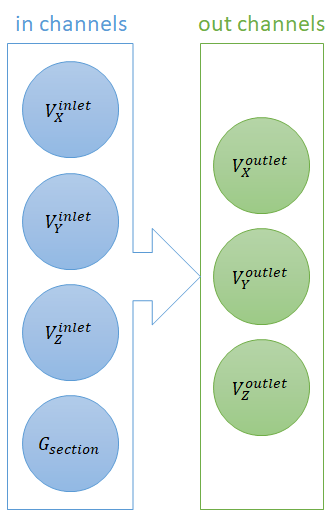

In [ ]:
class UNetEx(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 filters=[16, 32, 64],
                 layers=3,
                 weight_norm=True,
                 batch_norm=True,
                 activation=nn.ReLU,
                 final_activation=None):
        
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels,
                                      filters,
                                      kernel_size,
                                      weight_norm,
                                      batch_norm,
                                      activation,
                                      layers)
        
        decoders = []
        for i in range(out_channels):
            decoders.append(create_decoder(1,
                                           filters,
                                           kernel_size,
                                           weight_norm,
                                           batch_norm,
                                           activation,
                                           layers))
            
        self.decoders = nn.Sequential(*decoders)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        
        return x, tensors, indices, sizes

    def decode(self, _x, _tensors, _indices, _sizes):
        
        y = []
        
        for _decoder in self.decoders:
            x = _x
            tensors = _tensors[:]
            indices = _indices[:]
            sizes = _sizes[:]
            for decoder in _decoder:
                tensor = tensors.pop()
                size = sizes.pop()
                ind = indices.pop()
                x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
                x = torch.cat([tensor, x], dim=1)
                x = decoder(x)
            y.append(x)
            
        return torch.cat(y, dim=1)

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)
        if self.final_activation is not None:
            x = self.final_activation(x)
        
        return x

In [ ]:
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    
    mse_loss = nn.MSELoss()
    
    loss = 0
    
    for i in range(len(y[0])):
        loss += mse_loss(output[:,i,:,:], y[:,i,:,:])
        
    loss = (loss)/channels_weights
    
    return torch.sum(loss), output
    
#     if len(y[0]) > 1:
# #         # MSE written by authors of project
# #         lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
# #         lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
# #         lossz = ((output[:,2,:,:] - y[:,2,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
#         # changed to pyTorch function
#         lossu = mse_loss(output[:,0,:,:], y[:,0,:,:])
#         lossv = mse_loss(output[:,1,:,:], y[:,1,:,:])
#         lossz = mse_loss(output[:,2,:,:], y[:,2,:,:])
        
#     loss = (lossu + lossv + lossz)/channels_weights
    
#     else:
#         # MAE written by authors of project
#         loss = torch.abs((output[:,0,:,:] - y[:,0,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 

In [ ]:
DATA_X_PATH = "D:/DataScience/FinalProject/dataX_model_V.pkl"
DATA_Y_PATH = "D:/DataScience/FinalProject/dataY_model_V.pkl"

# Loading dataset
x = pickle.load(open(DATA_X_PATH, "rb"))
y = pickle.load(open(DATA_Y_PATH, "rb"))

assert len(x) == len(y)

# Shuffling dataset
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
x = np.array(x)[indices]
y = np.array(y)[indices]

In [ ]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

x_Ns, x_Nc, x_Nx, x_Ny = x.shape
y_Ns, y_Nc, y_Nx, y_Ny = y.shape

# channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1)\
#                                          .reshape((y_Ns*y_Nx*y_Ny, y_Nc)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)

# print(channels_weights)

channels_weights = 1

In [ ]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [ ]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

In [ ]:
config = {}        
train_loss_curve = []
test_loss_curve = []

train_mse_curve = []
test_mse_curve = []

train_ux_curve = []
test_ux_curve = []

train_uy_curve = []
test_uy_curve = []

train_uz_curve = []
test_uz_curve = []

# train_p_curve = []
# test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    
    train_ux_curve.append(scope["train_metrics"]["ux"])
    test_ux_curve.append(scope["val_metrics"]["ux"])
    
    train_uy_curve.append(scope["train_metrics"]["uy"])
    test_uy_curve.append(scope["val_metrics"]["uy"])
    
    train_uz_curve.append(scope["train_metrics"]["uz"])
    test_uz_curve.append(scope["val_metrics"]["uz"])
    
#     train_p_curve.append(scope["train_metrics"]["p"])
#     test_p_curve.append(scope["val_metrics" ]["p"])

### Training model

In [ ]:
# Learning parameters

lr = 0.0001
kernel_size = 9
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005

model = UNetEx(x_Nc,
               y_Nc,
               filters=filters,
               kernel_size=kernel_size,
               batch_norm=bn,
               weight_norm=wn,
               activation=nn.ReLU)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

BATCH_SIZE = 64
EPOCHS = 1000

In [ ]:
mse_loss = nn.MSELoss()

model_v, train_metrics, train_loss, test_metrics, test_loss = train_model(model,
                                                                          loss_func,
                                                                          train_dataset,
                                                                          test_dataset,
                                                                          optimizer,
                                                                          epochs=EPOCHS,
                                                                          batch_size=BATCH_SIZE,
                                                                          device=device,
                                                                          m_mse_name="Total MSE",
#                                                                           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
                                                                          m_mse_on_batch=lambda scope: mse_loss(scope["output"], scope["batch"][1]).item(),
                                                                          m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_ux_name="Ux MSE",
#                                                                           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
                                                                          m_ux_on_batch=lambda scope: mse_loss(scope["output"][:,0,:,:], scope["batch"][1][:,0,:,:]).item(),
                                                                          m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uy_name="Uy MSE",
#                                                                           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
                                                                          m_uy_on_batch=lambda scope: mse_loss(scope["output"][:,1,:,:], scope["batch"][1][:,1,:,:]).item(),
                                                                          m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uz_name="Uz MSE",
#                                                                           m_uz_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
                                                                          m_uz_on_batch=lambda scope: mse_loss(scope["output"][:,2,:,:], scope["batch"][1][:,2,:,:]).item(),
                                                                          m_uz_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          patience=25,
                                                                          after_epoch=after_epoch)

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss

curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve

curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve

curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve

curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve

curves["train_uz_curve"] = train_uz_curve
curves["test_uz_curve"] = test_uz_curve

config["metrics"] = metrics
config["curves"] = curves

with open(simulation_directory + "results_ModelV.json", "w") as file:
    json.dump(config, file)

out = model_v(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())

In [ ]:
visualize(test_y.cpu().detach().numpy(),
          out.cpu().detach().numpy(),
          error.cpu().detach().numpy())

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Test Error (MSE)', y=0.91, fontsize=24)

curve2plot = list(curves.keys())[2:]

for i in range(4):
    axs[i//2][i%2].plot(curves[curve2plot[i*2]], label='train')
    axs[i//2][i%2].plot(curves[curve2plot[i*2+1]], label='test')
    axs[i//2][i%2].grid(alpha=0.5)
#     axs[i//2][i%2].set_title(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_ylabel(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_xlabel('Epoch', fontsize=18)

plt.savefig(simulation_directory + 'MSE_ModelV.png')

## Model P

##### "Pressure+Velocity to Pressure"

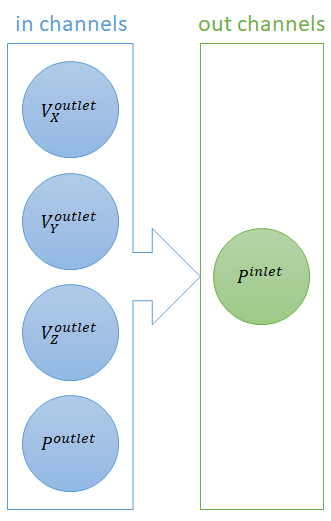

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, filters=[16, 32, 64], layers=2,
                 weight_norm=True, batch_norm=True, activation=nn.ReLU, final_activation=None):
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)
        self.decoder = create_decoder(out_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        return x, tensors, indices, sizes

    def decode(self, x, tensors, indices, sizes):
        for decoder in self.decoder:
            tensor = tensors.pop()
            size = sizes.pop()
            ind = indices.pop()
            x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
            x = torch.cat([tensor, x], dim=1)
            x = decoder(x)
        return x

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

In [ ]:
# def loss_func(model, batch):
#     x, y = batch
#     output = model(x)
    
#     mae_loss = nn.L1Loss()
    
#     loss = 0
    
#     for i in range(len(y[0])):
#         loss += mae_loss(output[:,i,:,:], y[:,i,:,:])
        
#     loss = (loss)/channels_weights
    
#     return torch.sum(loss), output

In [ ]:
DATA_X_PATH = "D:/DataScience/FinalProject/dataX_model_P.pkl"
DATA_Y_PATH = "D:/DataScience/FinalProject/dataY_model_P.pkl"

# Loading dataset
x = pickle.load(open(DATA_X_PATH, "rb"))
y = pickle.load(open(DATA_Y_PATH, "rb"))

assert len(x) == len(y)

# Shuffling dataset
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
x = np.array(x)[indices]
y = np.array(y)[indices]

In [ ]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

x_Ns, x_Nc, x_Nx, x_Ny = x.shape
y_Ns, y_Nc, y_Nx, y_Ny = y.shape

# channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1)\
#                                          .reshape((y_Ns*y_Nx*y_Ny, y_Nc)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)

# print(channels_weights)

channels_weights = 1

In [ ]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [ ]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

In [ ]:
config = {}        
train_loss_curve = []
test_loss_curve = []

train_mse_curve = []
test_mse_curve = []

train_p_curve = []
test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    
    train_p_curve.append(scope["train_metrics"]["p"])
    test_p_curve.append(scope["val_metrics" ]["p"])

### Training model

In [ ]:
# Learning parameters

lr = 0.0001
kernel_size = 9
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005

model = UNet(x_Nc,
             y_Nc,
             filters=filters,
             kernel_size=kernel_size,
             batch_norm=bn,
             weight_norm=wn,
             activation=nn.ReLU)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

BATCH_SIZE = 64
EPOCHS = 1000

In [ ]:
mse_loss = nn.MSELoss()

model_p, train_metrics, train_loss, test_metrics, test_loss = train_model(model,
                                                                          loss_func,
                                                                          train_dataset,
                                                                          test_dataset,
                                                                          optimizer,
                                                                          epochs=EPOCHS,
                                                                          batch_size=BATCH_SIZE,
                                                                          device=device,
                                                                          m_mse_name="Total MSE",
#                                                                           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
                                                                          m_mse_on_batch=lambda scope: mse_loss(scope["output"], scope["batch"][1]).item(),
                                                                          m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_p_name="P MSE",
#                                                                           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
                                                                          m_p_on_batch=lambda scope: mse_loss(scope["output"][:,0,:,:], scope["batch"][1][:,0,:,:]).item(),
                                                                          m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          patience=25,
                                                                          after_epoch=after_epoch)

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss

curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve

curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve

curves["train_p_curve"] = train_p_curve
curves["test_p_curve"] = test_p_curve

config["metrics"] = metrics
config["curves"] = curves

with open(simulation_directory + "results_ModelP.json", "w") as file:
    json.dump(config, file)

out = model_p(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())

In [ ]:
visualize(test_y.cpu().detach().numpy(),
          out.cpu().detach().numpy(),
          error.cpu().detach().numpy())

In [ ]:
curve2plot = list(curves.keys())[2:]
n_plots = int(len(curve2plot)/2)
n_rows = int(math.ceil(n_plots/2))

fig, axs = plt.subplots(n_rows, 2, figsize=(20, n_rows*10))
fig.suptitle('Test Error (MSE)', y=0.93, fontsize=24)

for i in range(n_plots):
    axs[i%2].plot(curves[curve2plot[i*2]], label='train')
    axs[i%2].plot(curves[curve2plot[i*2+1]], label='test')
    axs[i%2].grid(alpha=0.5)
#     axs[i%2].set_title(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i%2].set_ylabel(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i%2].set_xlabel('Epoch', fontsize=18)

plt.savefig(simulation_directory + 'MSE_ModelP.png')

# Inference

In [ ]:
df = pd.read_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'))

In [ ]:
initial_velocity = []
initial_pressure = []

row = 0

for v in ['Ux', 'Uy', 'Uz']:
    img, _, _ = get_preprocessed_image(column='inlet-' + v + '_image', row=row)
    initial_velocity.append(img)

img, img_h, img_w = get_preprocessed_image(column='outlet-P_image', row=row)
initial_pressure.append(img)

In [ ]:
geom_param_converter = {'previous':{'size':{'nothing':0,
                                            '50':1,
                                            '100':2},
                                    'shape':{'nothong':0,
                                             'arc45':1,
                                             'arc90':2,
                                             'line':3},
                                    'direction':{'nothong':0,
                                                 'left':1} },
                        
                        'current':{'size':{'50':0,
                                           '100':1},
                                   'shape':{'arc45':0,
                                            'arc90':1,
                                            'line':2},
                                   'direction':{'down':0,
                                                'left':1,
                                                'right':2,
                                                'top':3} },
                        
                        'next':{'size':{'nothing':0,
                                        '50':1,
                                        '100':2},
                                'shape':{'nothing':0,
                                         'arc45':1,
                                         'arc90':2,
                                         'line':3},
                                'direction':{'nothing':0,
                                             'down':0,
                                             'left':1,
                                             'right':2,
                                             'top':3} }
                       }

In [ ]:
'''Available shapes:
    size = [50, 100],
    shape = [arc45, arc90, line],
    direction = [down, left, right, top]
    (If shape is "line" then direction can only be "left")'''

pipe_config = {'section_1':['100','line','left'],
               'section_2':['50','arc45','top'],
               'section_3':['50','line','left'],
               'section_4':['100','arc90','right']}

for i in pipe_config.keys():
    for j, k in enumerate(geom_param_converter['current'].keys()):
        pipe_config[i][j] = geom_param_converter['current'][k][pipe_config[i][j]]


input_pipe_config = []

for i in range(enumerate(pipe_config)):
    
    section_geom_param = []
    
    s = (img_h, img_w)
    geom_param = np.zeros(s)
    
    if i == 0:
        section_geom_param += [0,0,0]
        section_geom_param += pipe_config['section_'+ i+1]
    else:
        section_geom_param += pipe_config['section_'+ i]
        section_geom_param += pipe_config['section_'+ i+1]
    
    if i == len(pipe_config)-1:
        section_geom_param += [0,0,0]
    else:
        section_geom_param += pipe_config['section_'+ i+2]
        
    
    for (h, w), x in zip(itertools.product(range(img_h), range(img_w)), itertools.cycle(section_geom_param)):
        geom_param.itemset((h, w), x)
    
    input_pipe_config.append(geom_param)

In [ ]:
model_v_out_list = []

for section in range(len(pipe_config)):
    
    if section == 0:
        channels_set = initial_velocity
    else:
        channels_set = model_v_out_list[section-1]
        
    channels_set.append(input_pipe_config[section])

    model_v_out_list.append(model_v(channels_set.to(device)))

In [ ]:
f = open(simulation_directory + 'model_v_out.pkl', 'wb')
    pickle.dump(model_v_out_list, f)

In [ ]:
plt.figure(figsize=(20,20))

for i, j in itertools.product(range(len(pipe_config)), range(3)):
    plt.subplot(len(pipe_config), 3, i+1)
    plt.imshow(model_v_out_list[i][j])
    plt.colorbar()

In [ ]:
model_p_out_list = []

for i in range(len(pipe_config)):
    
    if i == 0:
        channels_set = initial_pressure
    else:
        channels_set = model_p_out_list[i-1]
    
    if i == len(pipe_config)-1:
        channels_set = channels_set + initial_velocity
    else:
        channels_set = channels_set + model_v_out_list[len(pipe_config)-(2+i)]

    model_p_out_list.append(model_p(channels_set.to(device)))

In [ ]:
f = open(simulation_directory + 'model_p_out.pkl', 'wb')
    pickle.dump(model_p_out_list, f)

In [ ]:
plt.figure(figsize=(20,5))

for i in range(len(pipe_config)):
    plt.subplot(1, len(pipe_config), i+1)
    plt.imshow(model_p_out_list[i])
    plt.colorbar()

## CFD results

In [ ]:
df_inference = pd.read_csv(os.path.join('D:/DataScience/FinalProject/inference/10-100-50-50-100', '10-100-50-50-100.csv'))
df_inference

In [ ]:
IMG_PATH = 'D:\\DataScience\\FinalProject\\inference\\10-100-50-50-100\\10-100-50-50-100-line-arc45-line-arc90-left-top-left-right\\'

img_list = []

for i in ['s0', 's4']:
    img_list += glob.glob(IMG_PATH + i + '*')

for img in img_list:
    new_column = os.path.basename(img).replace('.png', '_image')
    df_inference[new_column] = img

df_inference

In [ ]:
inference_image = []

for col in df_inference.columns[-len(img_list):]:
    img, _, _ = get_preprocessed_image(column=col, row=0, ratio=4, df=df_inference, save=False, data_path=DATA_PATH)
    inference_image.append(img)

In [ ]:
plt.figure(figsize=(20,6), tight_layout=True)

for i, j in enumerate(img_list):
    name = os.path.basename(j).replace('.png', '')
    plt.subplot(2, len(img_list)//2, i+1)
    plt.imshow(inference_image[i])
    plt.title(name)
    plt.colorbar()

# Comparison

In [ ]:
model_v_err = []

for v in range(1, 4):
    err = model_v_out_list[-1][-v] - inference_image[-v]
    model_v_err.append(err)

In [ ]:
model_p_err = model_p_out_list[-1] - inference_image[0]

In [ ]:
plt.figure(figsize=(20,6), tight_layout=False)

for i in range(len(model_v_err)+1):
    
    if i == len(model_v_err):
        img2prnt = model_p_err
    else:
        img2prnt = model_v_err[i]
        
    plt.subplot(1, len(model_v_err)+1, i+1)
    plt.imshow(img2prnt)
    plt.colorbar()